In [4]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import pymc3 as pm
import pandas as pd
import warnings

plt.style.use("seaborn-darkgrid")
#az.style.use("seaborn-darkgrid")

AttributeError: module 'arviz' has no attribute 'geweke'

## Data Generation

Intercept: 0.5
Slope: 3
Noise: 2


,x,y
0,0.00,2.114307
1,0.01,1.046414
2,0.02,-5.001609
3,0.03,1.466421
4,0.04,0.434378
...,...,...
995,9.95,28.457367
996,9.96,31.532015
997,9.97,31.685905
998,9.98,33.791584


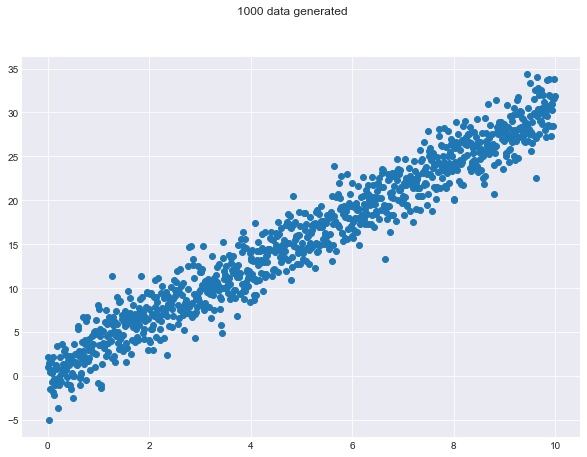

In [137]:
def data_generator(x,noise,intercept,slope):
    y=[]
    for i in range(0,int(len(x))):
        y.append(intercept+slope*x[i]+noise[i])
    
    return np.array(y)


x=np.arange(0,10,0.01)

N=len(x)
intercept=0.5
slope=3
noise_var=2

noise=np.random.normal(0,noise_var,N)

y=data_generator(x,noise,intercept,slope)

print("Intercept:", intercept)
print("Slope:", slope)
print("Noise:",noise_var)

fig=plt.figure(figsize=(10,7))
fig.suptitle("{} data generated".format(N))
ax=fig.add_subplot()
ax.scatter(x,y);

data=pd.DataFrame(dict(x=x,y=y))
data

## Ordinary Least Squares

In [149]:
X = sm.add_constant(data['x'])
Y = data['y']
reg = sm.OLS(Y, X)

model_freq = reg.fit()
print(model_freq.summary())

intercept_ols, slope_ols = model_freq.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 1.798e+04
Date:                Tue, 24 May 2022   Prob (F-statistic):               0.00
Time:                        12:13:09   Log-Likelihood:                -2131.1
No. Observations:                1000   AIC:                             4266.
Df Residuals:                     998   BIC:                             4276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5814      0.129      4.508      0.0

/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Intercept: 0.581364606860874
Slope: 2.997659123874044


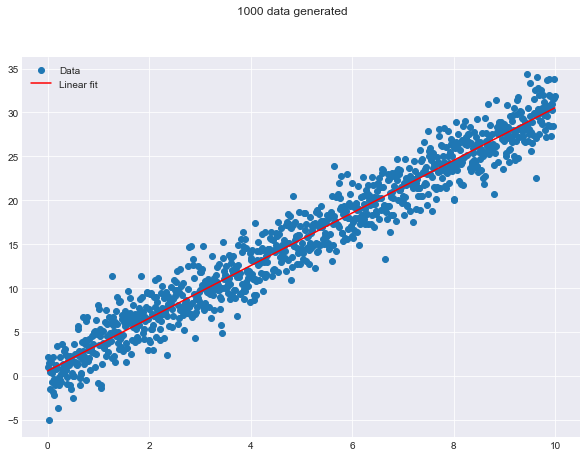

In [150]:
print(f'Intercept: {intercept_ols}')
print(f'Slope: {slope_ols}')

fig=plt.figure(figsize=(10,7))
fig.suptitle("{} data generated".format(N))
ax=fig.add_subplot()
ax.scatter(data.x,data.y,label="Data")
ax.plot(data.x,intercept_ols+slope_ols*data.x,color="red",label="Linear fit")
ax.legend();

## Bayesian Model


In [155]:
# Given your data, how your coefficients is going to be distributed

with pm.Model() as model:
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    slope = pm.HalfCauchy('Slope', beta=10, testval=1.0)
    sigma = pm.HalfCauchy('Sigma', beta=10, testval=1.0)
    
    # Estimate of mean
    mu = intercept + slope * data.x
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=data.y)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    trace = pm.sample(10000, step)

    

/var/folders/0d/wr4vslms6rx70gkgwp1_dz400000gn/T/ipykernel_57531/2489141989.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, step)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Slope, Intercept]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8857480383122838, but should be close to 0.8. Try to increase the number of tuning steps.
Th

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.58,0.13,0.33,0.83,0.0,0.0,17949.29,19563.97,1.0
Slope,3.00,0.02,2.95,3.04,0.0,0.0,18164.75,19345.11,1.0
Sigma,2.04,0.05,1.96,2.13,0.0,0.0,23038.34,22022.41,1.0


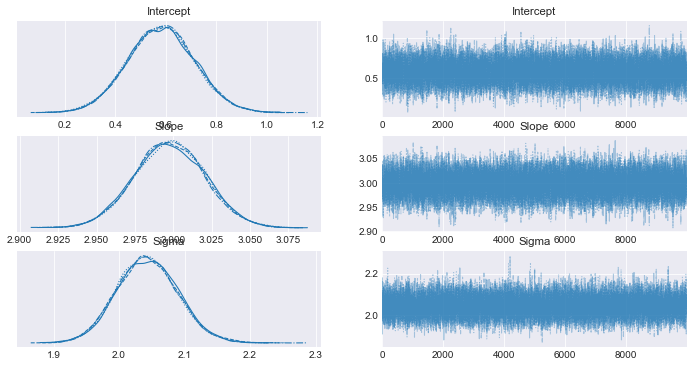

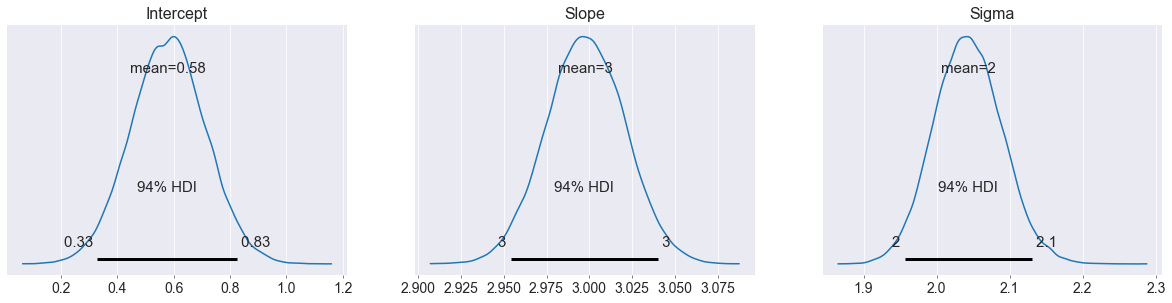

In [156]:
with model:
    az.plot_trace(trace);
    pm.plot_posterior(trace)
    display(az.summary(trace, round_to=2))


In [157]:
A=np.mean(trace["Intercept"])
B=np.mean(trace["Slope"])

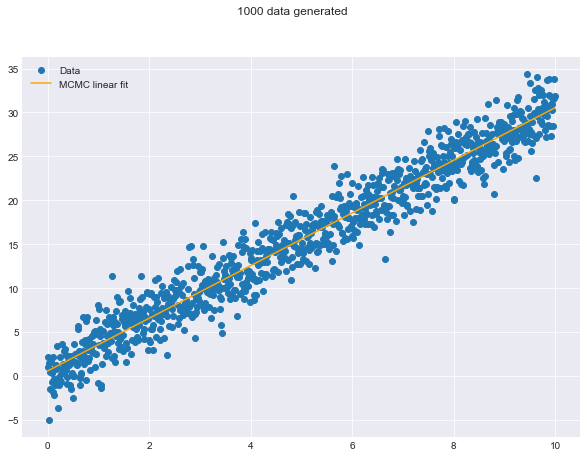

In [158]:
fig=plt.figure(figsize=(10,7))
fig.suptitle("{} data generated".format(N))
ax=fig.add_subplot()
ax.scatter(data.x,data.y,label="Data")
ax.plot(data.x,A+B*data.x,color="orange",label="MCMC linear fit")
ax.legend();